## SLAP2 Utils Example Notebook

This notebook will highlight core features included in `SLAP2_Utils`. The example will demonstrate how to extract useful metadata, extract a trace signal, and use basic plotting. This will give users a better understanding of how to work with the library with their own data. For further information on any functions used in the notebook, please reference the [documentation](https://peter-hogg.github.io/SLAP2_Utils/)


### Loading a Data File
Loading data from a SLAP2 binary file requires importing the DataFile class from the library. The coorsponding meta data file should be in the same directory with the same file name. If either of these conditions are not met, then an error will be thrown during loading

In [1]:
from slap2_utils.datafile import DataFile

In [2]:
binaryFilePath = "3DExampleScan.dat"
dataFile = DataFile(binaryFilePath)

Basic information about the acquisition is stored inside the file header. We can inspect this by accessing the header attribute in the datafile object. This attribute stores information inside a dictionary.

In [3]:
display(dataFile.header)

{'firstCycleOffsetBytes': 136.0,
 'lineHeaderSizeBytes': 40.0,
 'laserPathIdx': 0.0,
 'bytesPerCycle': 31270.0,
 'linesPerCycle': 302.0,
 'superPixelsPerCycle': 9595.0,
 'dmdPixelsPerRow': 1280.0,
 'dmdPixelsPerColumn': 800.0,
 'numChannels': 1.0,
 'channelMask': 1.0,
 'numSlices': 28.0,
 'channelsInterleave': 0.0,
 'fpgaSystemClock_Hz': 200000000.0,
 'referenceTimestamp_lower': 3670612649.0,
 'referenceTimestamp_upper': 197.0,
 'channels': [0],
 'referenceTimestamp': 849779169961,
 'file_version': 2,
 'magic_start': 322379495,
 'magic_end': 322379495}

If we wanted to access specific information stored in the header we can do so by using the corresponding key. For this simulated recording we can tell that simulated scan is a single channel volumetric recording with 28 slices.

In [4]:
print('Number of imaging planes: ', dataFile.header['numSlices'], '\nList of recorded channels :',dataFile.header['channels'])

Number of imaging planes:  28.0 
List of recorded channels : [0]


### Inspecting Acquisition Metadata
Once loaded into Python, the acquisition metadata is stored in the `MetaData` subclass of the `DataFile` object. This object has more detailed information about the microscope settings during the acquisition.

In [5]:
# Here is an example of import data stored in the `MetaData` object
print('The laser AOM was set to: ', dataFile.metaData.aomVoltage)
print('The duration of the acquisition was', dataFile.metaData.acqDuration_s, 'secs')
      

The laser AOM was set to:  1.9500000000000002
The duration of the acquisition was 10.0 secs


The `MetaData` object is the parent object of other objects, such as the `AcquisitionContainer`, which stores a list of all regions of interest (ROI). Information for each ROI is stored in `slapROI` objects. Now we'll look at how to pull out this information 

In [6]:
print('The number of ROIs in the acquistion is: ', len(dataFile.metaData.AcquisitionContainer.ROIs))

The number of ROIs in the acquistion is:  643


Let's look at the information stored in a `slapROI` object.
* `slapROI.imageMode`: SLAP2 has two types of ROIs, raster and integrated
* `slapROI.roiType`: ROI shapes can be rectangular or arbitrary
* `slapROI.shapeData`: Arbitrary ROI shapes are stored in a series of coordinates
* `slapROI.z`: The remote focusing positiion is stored in the z attribute

['slapROI' documentation](https://peter-hogg.github.io/SLAP2_Utils/modules/slapROI.html)

In [7]:
print("ROI Imaging Mode: ", dataFile.metaData.AcquisitionContainer.ROIs[0].imageMode, "\n")
print("ROI Type: ", dataFile.metaData.AcquisitionContainer.ROIs[0].roiType, "\n")
print("Shape Data: ", dataFile.metaData.AcquisitionContainer.ROIs[0].shapeData, "\n")
print("Remote focusing position (um): ", dataFile.metaData.AcquisitionContainer.ROIs[0].z, "\n")


ROI Imaging Mode:  Integrate 

ROI Type:  ArbitraryRoi 

Shape Data:  [[375. 376. 374. 375. 376. 377. 374. 375. 376. 377. 374. 375. 376. 375.]
 [716. 716. 717. 717. 717. 717. 718. 718. 718. 718. 719. 719. 719. 720.]] 

Remote focusing position (um):  229.0 



'SLAP2_Utils' has inbuilt utils for interacting with ROI shape data which may be useful for users building analysis or visualization pipelines. These are stored in `slap2_utils.utils.roi_utils`. Let's look at these functions

In [8]:
from slap2_utils.utils import roi_utils
import matplotlib.pyplot as plt
import numpy as np

`roi_utils.roiImg` will return a 2D array of the optical plane the ROI is in (`slapROI.z`). Pixels belonging to the ROI will be set to the value one, while the other pixels will be set to a value of 0.

`roi_utils.roiBoolean' returns the same data but as a boolean, which is useful for generating activity traces

`roi_utils.roiLabels' returns either a 2D or 3D label array, representing each ROI as an integer. An option argument is a path of a SLAP2 reference TIF file, which will match the ROI position in Z to image slices in the volumetric TIF file.

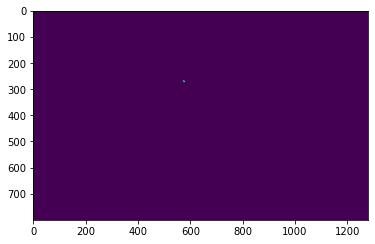

[False  True]


In [9]:
# Plotting the pixels belonging to the ROI at index 10 in dataFile.metaData.AcquisitionContainer.ROIs
roi_utils.roiImg(dataFile, 10)
plt.imshow(roi_utils.roiImg(dataFile, 10))
plt.show()

# The same data in an boolean array
print(np.unique(roi_utils.roiBoolean(dataFile, 10)))


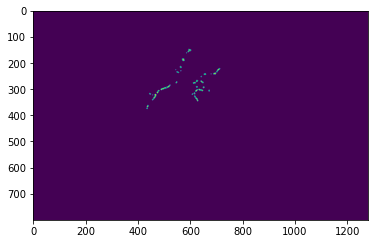

In [10]:
# Ploting all the ROIs on a particular plane of the acquisition
roiLabelArray = roi_utils.roiLabels(dataFile)
plt.imshow(roiLabelArray[15, :, :])
plt.show()

### Plotting 
`SLAP2_Utils` has a few basic plotting features to better visualize the data in ROIs

In [11]:
from slap2_utils.utils.plots import slap2Plots


NameError: name 'SP2roi' is not defined

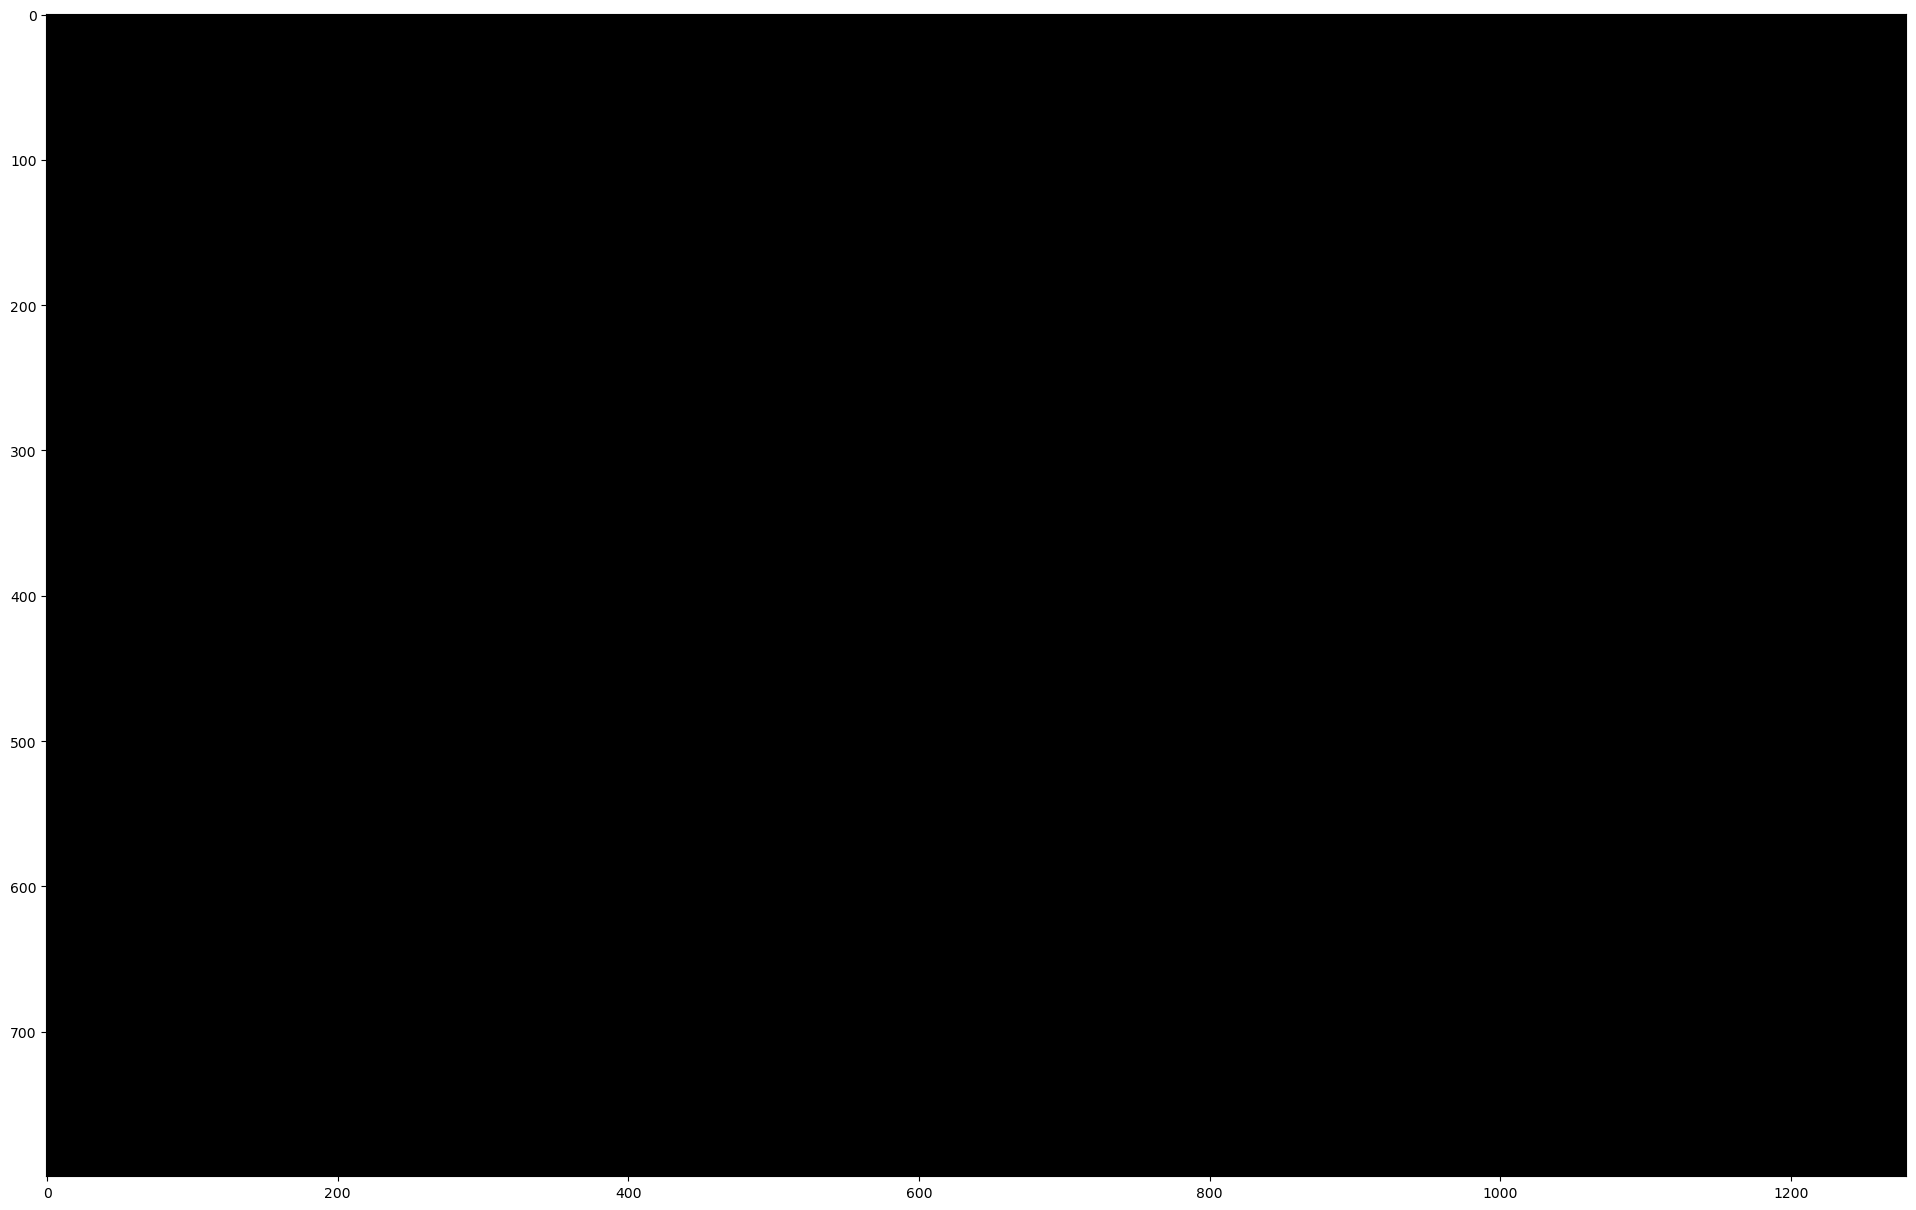

In [12]:
slap2Plots.roiOverlaySuperPix(dataFile, np.zeros_like(roiLabelArray), 120)

### Trace Extraction
Trace extraction can be handled directly using the `Trace` object. However, `SLAP2_Utils` includes helper functions to streamline this process further.

In [13]:
from slap2_utils.utils import trace
from slap2_utils.functions import tracefunctions

5


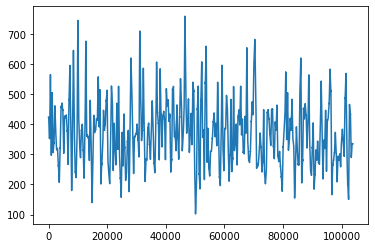

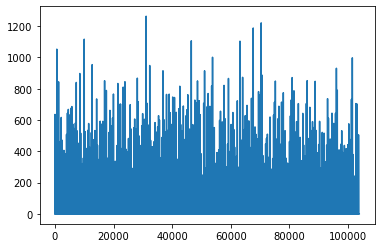

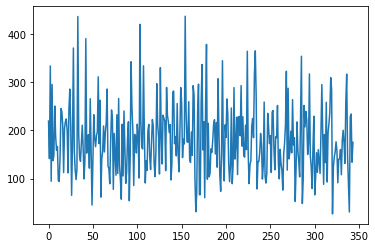

In [14]:
# Let's extract a trace for ROI 15
# we need to get determine what channel, there is only one in this simulated recording
chIdx = 1
# We need to find the ROI's Z position in the fastz of the DataFile
roi15 = dataFile.metaData.AcquisitionContainer.ROIs[15]
zIdx = dataFile.fastZs.index(roi15.z)
print(zIdx)


# Can now initialize the Trace object
Trace = trace.Trace(dataFile, zIdx, chIdx)

# We need to set the pixel mask for Trace generation
roi15Mask = roi_utils.roiBoolean(dataFile, 15)

# Exclude any raster-mode pixels
rasterPixels = None

Trace.setPixelIdxs(rasterPixels, roi15Mask)

#We can smooth the trace with temporal weights 
trace15, sumDataWeighted, sumExpected, sumExpectedWeighted  = Trace.process(150, 1000)
plt.plot(trace15)
plt.show()

# Or we can set the weighted windows to 1 and return the raw trace
rawtrace15, sumDataWeighted, sumExpected, sumExpectedWeighted  = Trace.process(1, 1)
plt.plot(rawtrace15)
plt.show()

# Traces from volumetric acquistions need to be futher processed to remove times when the the microscope was focused on a different plane
Trace.orderadjust()
volumetricTrace15 = tracefunctions.cleanVolumeTrace(dataFile, zIdx, rawtrace15)
plt.plot(volumetricTrace15)
plt.show()

All of these steps can excuted using the `returnVolumeTrace` function

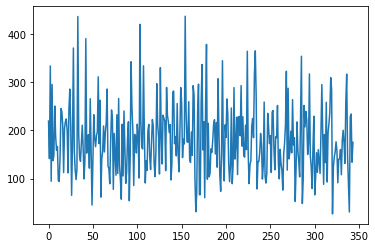

In [15]:
rawTrace15, volumeTrace15 = tracefunctions.returnVolumeTrace(dataFile, 15)
plt.plot(volumeTrace15)
plt.show()